In [139]:
import gc;
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers, models
from keras.utils.test_utils import get_test_data
from skimage.morphology import binary_opening
from skimage.segmentation import mark_boundaries
from skimage.util import montage

from config import IMG_SCALING, TRAIN_DIR, CHECKPOINTS_DIR, TEST_DIR, INPUT_DIR, DEFAULT_THRESHOLDS
from prepare_datasets import load_dataset, drop_empty_images, split_validation_dataset, get_train_val_datasets, \
    get_unique_img_ids
from utils.data_utils import make_image_gen
from utils.rle_utils import rle_encode, multi_rle_encode, masks_as_color, masks_as_image

gc.enable()  # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

print(os.listdir("input"))


['test_ship_segmentations.csv', 'sample_submission.csv', 'train_ship_segmentations.csv', 'test', 'train']


In [102]:
df = load_dataset()
df.head()


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


# 1. Training dataset stats

In [3]:
# 1. Use only image with ships
# 2. Pretrained U-net CNN model, ResNet, Ternaus on ImageNet
# 3. Try to learn on 768x768 images


# TODO:
# 1. Check results
# 2. Crete repo for models and learning them by scripts with notbooks only to visualization and predicting

In [103]:
num_of_all_images = len(df.drop_duplicates('ImageId'))
num_of_no_ships_images = sum(pd.isnull(df['EncodedPixels']))
num_of_all_rows = len(df)

print("Number of images: {}".format(num_of_all_images))
print("Number of images without ships: {}".format(num_of_no_ships_images))
print("Number of images with ships: {}".format(num_of_all_images - num_of_no_ships_images))
print("Number of ships: {}".format(num_of_all_rows - num_of_no_ships_images))

# We can consider that dataset is not balanced enough, let's remove empty images.

Number of images: 104070
Number of images without ships: 75000
Number of images with ships: 29070
Number of ships: 56030


# 2. RLE encoding and decoding

## Check if above functions work properly

In [104]:
df.loc[df['ImageId'] =="00021ddc3.jpg"]

,ImageId,EncodedPixels
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
5,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...
6,00021ddc3.jpg,139644 2 140408 6 141174 9 141942 9 142711 6 1...
7,00021ddc3.jpg,86727 2 87493 4 88261 4 89030 3 89798 4 90566 ...
8,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
9,00021ddc3.jpg,75972 3 76738 5 77506 5 78274 5 79042 6 79811 ...
10,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


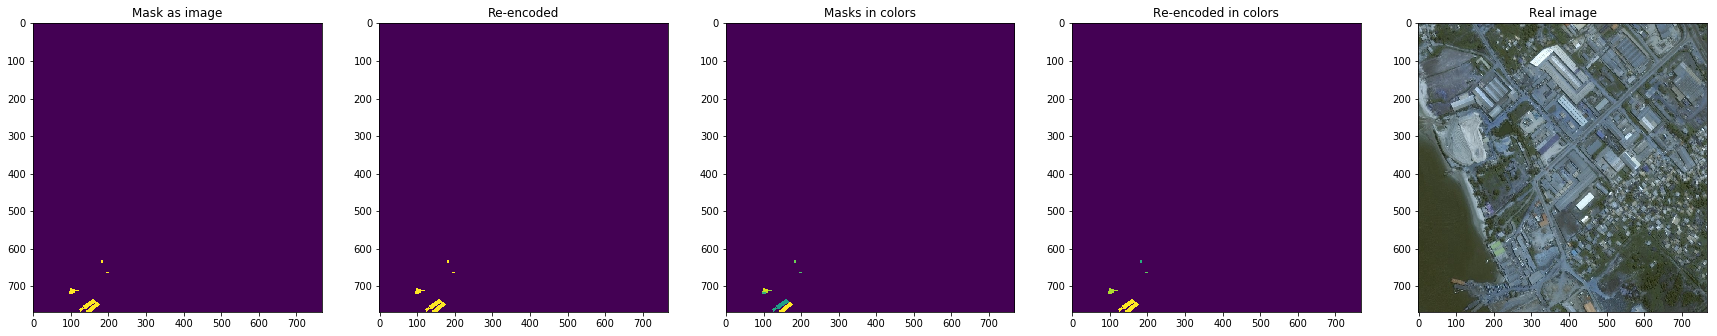

In [105]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (30, 10))
rle_0 = df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_2 = masks_as_color(rle_0)
ax3.imshow(img_2)
ax3.set_title('Masks in colors')
img_3 = masks_as_color(rle_1)
ax4.imshow(img_3)
ax4.set_title('Re-encoded in colors')

img_4 = cv2.imread(os.path.join(TRAIN_DIR, '00021ddc3.jpg'))
ax5.imshow(img_4)
ax5.set_title('Real image')


print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

# 3. Split to taining and validation datasets

,ImageId,ships,has_ship,file_size_kb
7622,126339a19.jpg,0,0.0,118.507812
95185,ea2ac86e0.jpg,0,0.0,107.171875
85111,d19cbbb15.jpg,2,1.0,68.878906
96617,edab79a0b.jpg,0,0.0,181.790039
76717,bca8cd4c0.jpg,0,0.0,214.791992
96492,ed5ef7c2d.jpg,0,0.0,107.208984
58629,902874686.jpg,0,0.0,118.962891


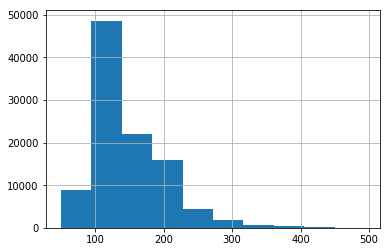

In [106]:
unique_img_ids = get_unique_img_ids(df)

unique_img_ids['file_size_kb'].hist()
unique_img_ids.sample(7)


## Ships number histogram

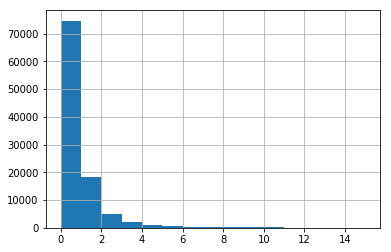

In [107]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

## Drop empty images

28693 masks


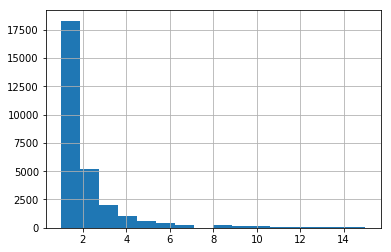

In [108]:
balanced_train_df = drop_empty_images(unique_img_ids)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')



In [109]:
train_df, valid_df = get_train_val_datasets(df, balanced_train_df)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
train_df.head()

16371 training masks
1911 validation masks


,ImageId,EncodedPixels,ships,has_ship,file_size_kb
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,1.0,147.625977
1,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1,1.0,232.898438
2,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...,1,1.0,197.588867
3,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...,1,1.0,305.848633
4,000e6378b.jpg,224667 2 225431 6 226196 10 226962 12 227730 1...,1,1.0,181.113281


## Create validation dataset

In [110]:
valid_x, valid_y = split_validation_dataset(valid_df)
print('x', valid_x.shape, valid_x.min(), valid_x.max())
print('y', valid_y.shape, valid_y.min(), valid_y.max())

x (3000, 256, 256, 3) 0.0 1.0
y (3000, 256, 256, 1) 0 1


Text(0.5,1,'Outlined Ships')

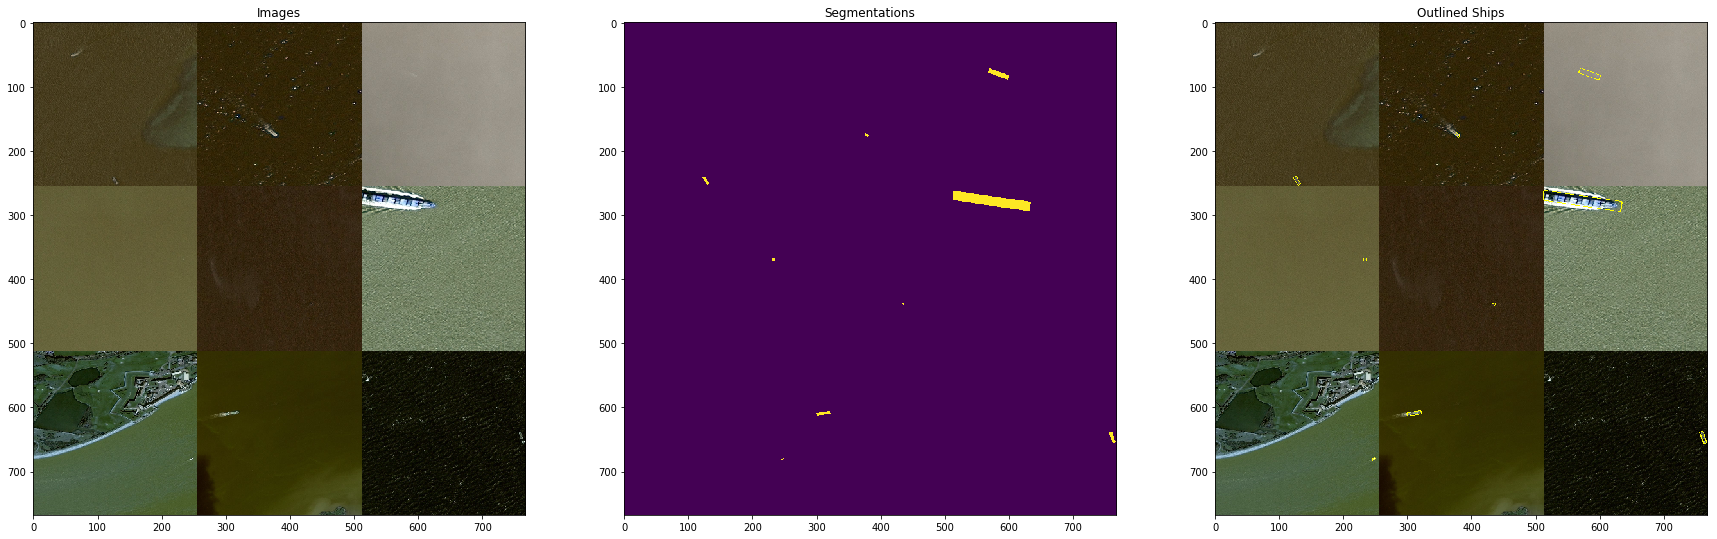

In [111]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(valid_x[:9])
batch_seg = montage(valid_y[:9, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax3.set_title('Outlined Ships')


In [112]:
gc.collect()

12

# 4. Model (run after fiting outside notebook)

In [113]:
from models import VGG19UNetV1
seg_model = VGG19UNetV1()
keras_model = seg_model.get_model()
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

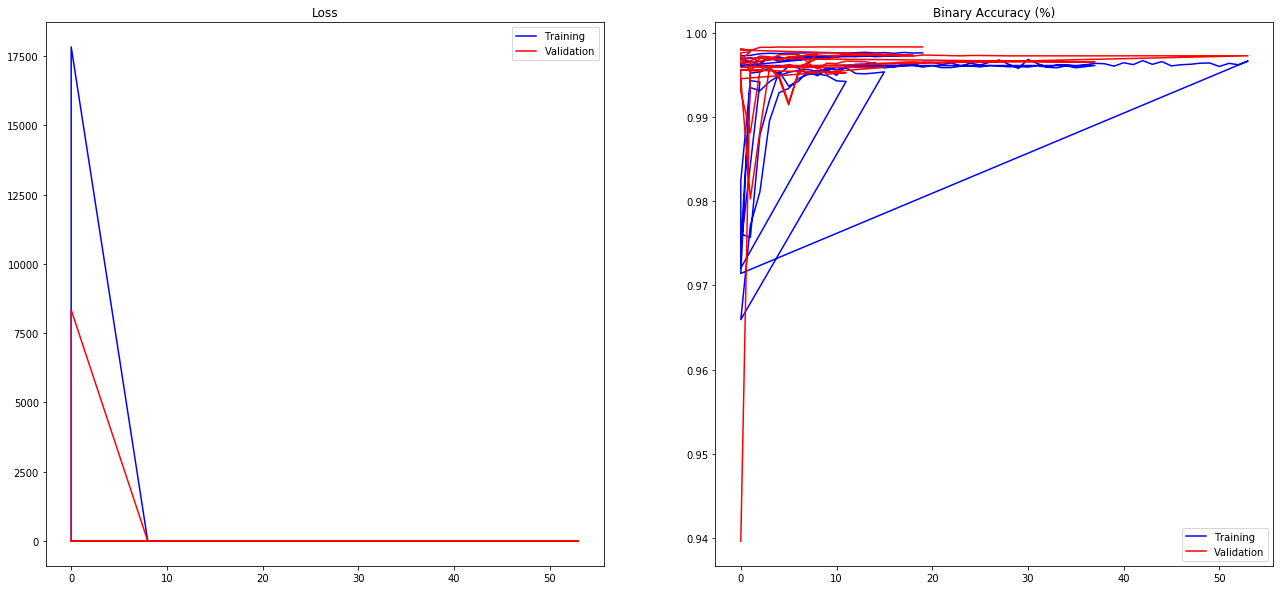

In [114]:
def show_loss(loss_history):
    epochs = loss_history.epoch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, loss_history.loss, 'b-',
                 epochs, loss_history.val_loss, 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, loss_history.binary_accuracy, 'b-',
                 epochs, loss_history.val_binary_accuracy, 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')




loss_history = pd.read_csv(seg_model.FIT_HISTORY_PATH, sep=';')
show_loss(loss_history)


In [115]:
keras_model.load_weights(seg_model.WEIGHT_PATH)
keras_model.save(os.path.join(CHECKPOINTS_DIR, '{}.h5'.format(seg_model.MODEL_NAME)))

In [116]:
pred_y = keras_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

(3000, 256, 256, 1) 1.9518755e-19 0.0028592206 0.0040953537


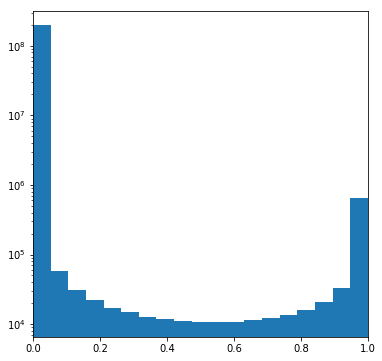

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

In [118]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(keras_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = keras_model
fullres_model.save(os.path.join(CHECKPOINTS_DIR, '{}.h5'.format(seg_model.FULL_RES_MODEL_NAME)))


In [146]:
import scipy.ndimage as ndi
import numpy as np


def IoU_measure(y_true, y_pred, thresh=0.5, eps=1e-6):
    y_pred = np.where(y_pred > thresh,1,0)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + eps) / (union + eps)


def do_opening(batch_input, kernel=np.ones((3,3)), thresh=0.5):
    a = np.where(batch_input > thresh,1,0)
    a = ndi.morphology.binary_erosion(a, (kernel)).astype(batch_input.dtype)
    a = ndi.label(a)[0]
    a = ndi.morphology.binary_dilation(a, kernel).astype(batch_input.dtype)
    return a


def kaggle_IoU_measure(y_true, y_pred, opening=False):
    score_list = []
    for thresh in DEFAULT_THRESHOLDS:
        if opening:
            y_pred = do_opening(y_pred, kernel=np.ones((1, 3, 3, 1)), thresh=thresh)
        iou = IoU(y_true, y_pred, thresh=thresh)
        score_list.append(iou)

    return np.mean(np.array(score_list))


In [147]:
pred_y = keras_model.predict(valid_x)
print('IoU:               ', kaggle_IoU_measure(valid_y, pred_y))

print('IoU after opening: ', kaggle_IoU_measure(valid_y, opened_pred, opening=True))

IoU:                0.668154627293431
IoU after opening:  0.6670375941707182


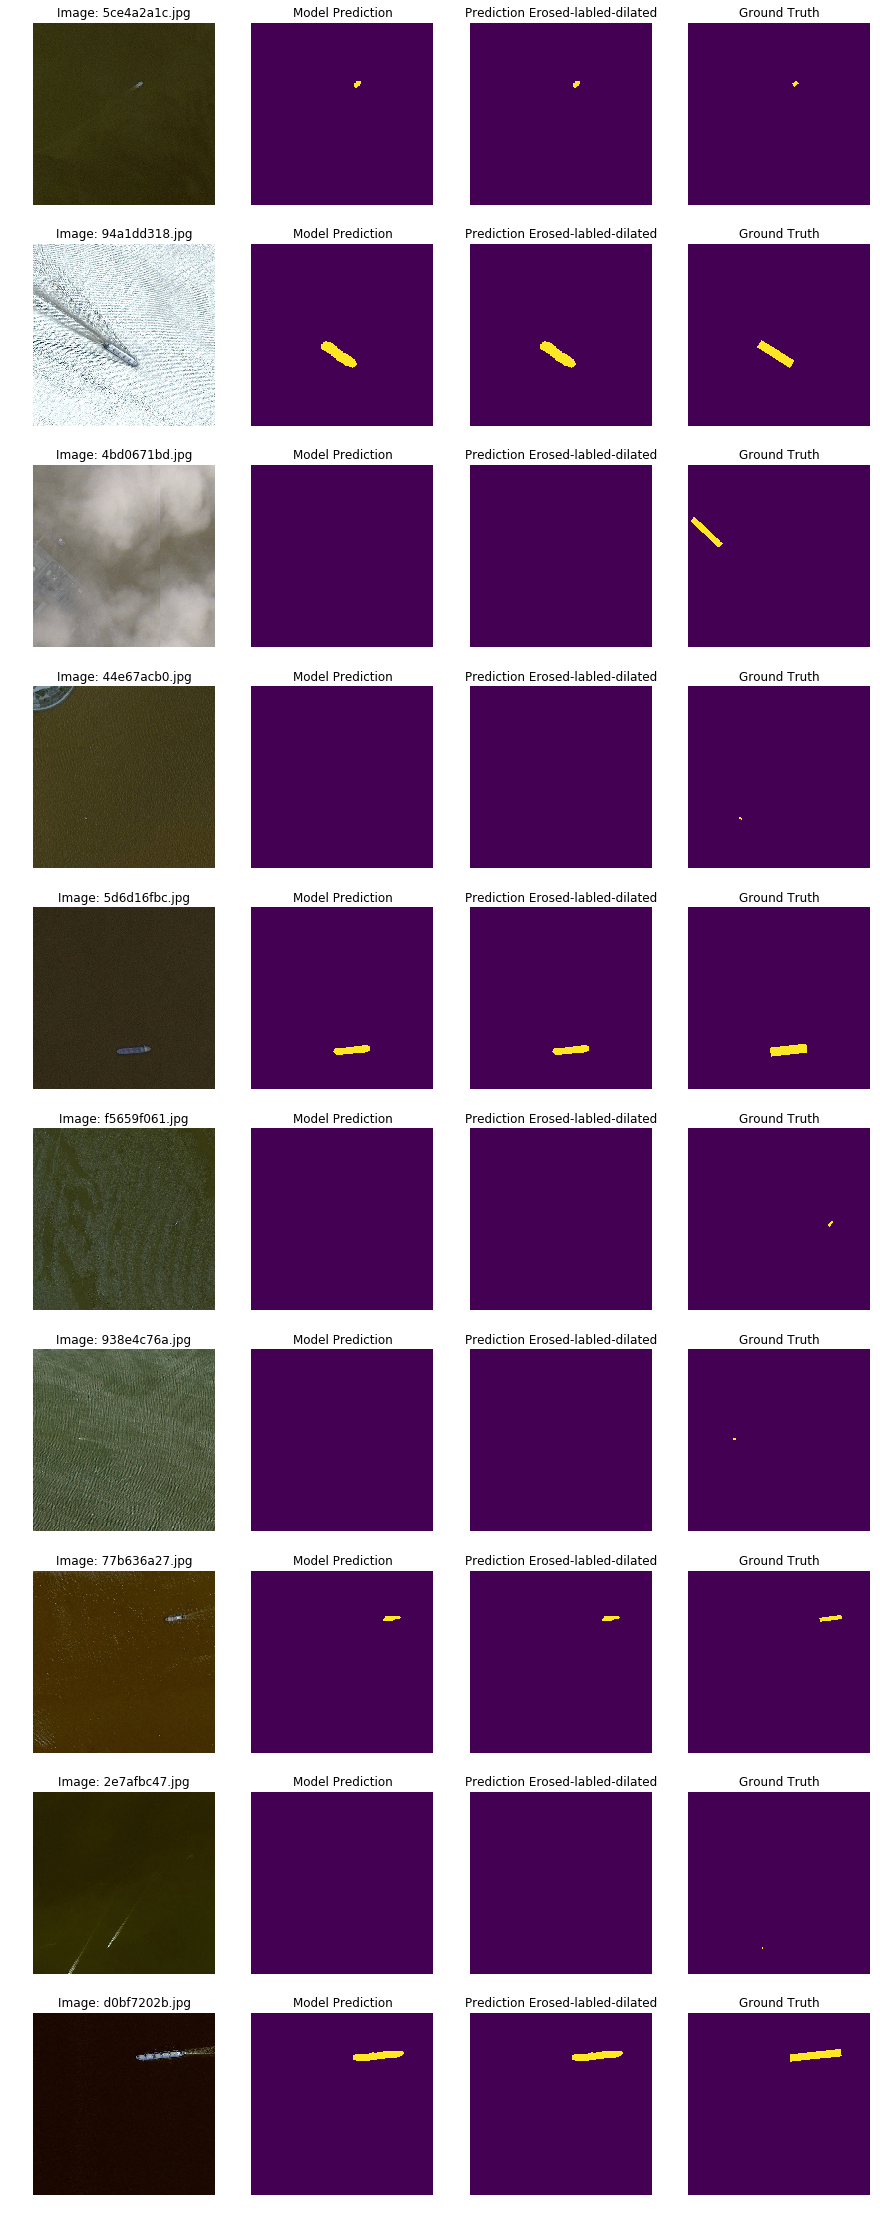

In [148]:
def predict(c_img_name, path=TEST_DIR, thresh=0.5):
    c_img = cv2.imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg[cur_seg > thresh] = 1
    cur_seg[cur_seg < thresh] = 0
    return cur_seg, c_img


## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(10))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = predict(c_img_name, TRAIN_DIR)
    opened_seg = do_opening(first_seg, kernel=np.ones((3,3,1)), thresh=0.5)
    ax1.imshow(first_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0])
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(first_seg[:, :, 0]))
    ax3.imshow(opened_seg[:, :, 0])
    ax3.set_title('Prediction Erosed-labled-dilated')
    ground_truth = masks_as_color(df.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
  
    
# fig.savefig('validation.png')

# 5. SUBMISSION

In [ ]:
test_paths = np.array(os.listdir(TEST_DIR))
print(len(test_paths), 'test images found')


In [ ]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:30000]): ## only a subset as it takes too long to run
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

In [ ]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

In [ ]:
## let's see what we got
TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = cv2.imread(os.path.join(TEST_DIR, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')

In [ ]:
sub1 = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission.csv', index=False)
sub.head()

